# El Salvador Tree Cover EDA with Rasterio


**Goals**
- Identify the mean tree cover by jurisdiction for the TOF and Hansen data.
- Identify the number of hectares w/ > 10% tree cover for TOF and Hansen data
- Create a .csv with `jursidiction`, `hansen_perc_cover`, `tof_perc_cover`, `hansen_forest_ha`, `tof_forest_ha`
- Learn how to use rasterio :) 

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

**Data**  
Data Download: As always, run in terminal rather than jupyter.
- sentinel_treecover.tif
- hansen_treecover.tif
- *.geojson - subnational jurisdictions

**Steps**
1. Explore the raster and shapefile.
2. Confirm CRS is the same in order to perform any analysis.
3. Mask rasters with shapefile of subnational jurisdictions
4. (arr - hansen) overall average % tree cover difference and difference in # hectares >10%


Eventually will look at:  
- In the future, we will want to be able to do these analyses by incorporating other datasets, such as ecoregion, land cover, aridity zone, etc. 
- ex: Hansen data shows 17% tree cover for rwanda and TOF data shows 32% tree cover for rwanda versus Hansen data shows 350,000 ha > 10% tree cover and TOF data shows 620,000 ha > 10% tree cover. Then eventually we can compute confidence interval for moist tropical broadleaf forests in central africa 620,000 +/- 25,000

In [1]:
!aws s3 cp s3://restoration-monitoring/restoration-mapper/tifs/ . --recursive

download: s3://restoration-monitoring/restoration-mapper/tifs/elsalvador_adm2.geojson to ./elsalvador_adm2.geojson
download: s3://restoration-monitoring/restoration-mapper/tifs/hansen_treecover.tif to ./hansen_treecover.tif
download: s3://restoration-monitoring/restoration-mapper/tifs/sentinel_treecover.tif to ./sentinel_treecover.tif


# EDA

In [82]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.plot import show, show_hist, adjust_band
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import pandas as pd
import fiona
from skimage.transform import resize

%matplotlib inline

## Explore TOF/Hansen Rasters

In [57]:
tof_data = rs.open("sentinel_treecover.tif")
tof_data.shape

(6309, 11801)

In [58]:
tof_data.bounds

BoundingBox(left=-90.036167469, bottom=13.417995853, right=-88.953163734, top=13.996986665)

In [59]:
# get the value for a pixel 100 km east and 50km south of the datasets upper left corner
x, y = (tof_data.bounds.left + 100_000, tof_data.bounds.top - 50_000)
row, col = tof_data.index(x, y)
row, col

(544827298, 1089654598)

In [60]:
print(f'Raster description: {tof_data.profile}')

Raster description: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11801, 'height': 6309, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.177220023726849e-05, 0.0, -90.036167469,
       0.0, -9.177220034870802e-05, 13.996986665), 'tiled': False, 'interleave': 'band'}


In [61]:
# get the coordinates of the center of the image
tof_data.xy(tof_data.height // 2, tof_data.width // 2)

(-89.4946656015, 13.707491259)

In [62]:
# read method returns an np array.
tof_data = tof_data.read(1)

In [63]:
# check band statistics
band_mean = np.mean(tof_data)
band_min = np.min(tof_data)
band_max = np.max(tof_data)
band_std = np.std(tof_data)
print(f'Mean: {band_mean} Range: {band_min} - {band_max} Standard Dev: {band_std}')

Mean: 31.304041869159843 Range: 0 - 99 Standard Dev: 42.364882030375746


In [64]:
# resize to be divisible by 10
tof_data.shape

(6309, 11801)

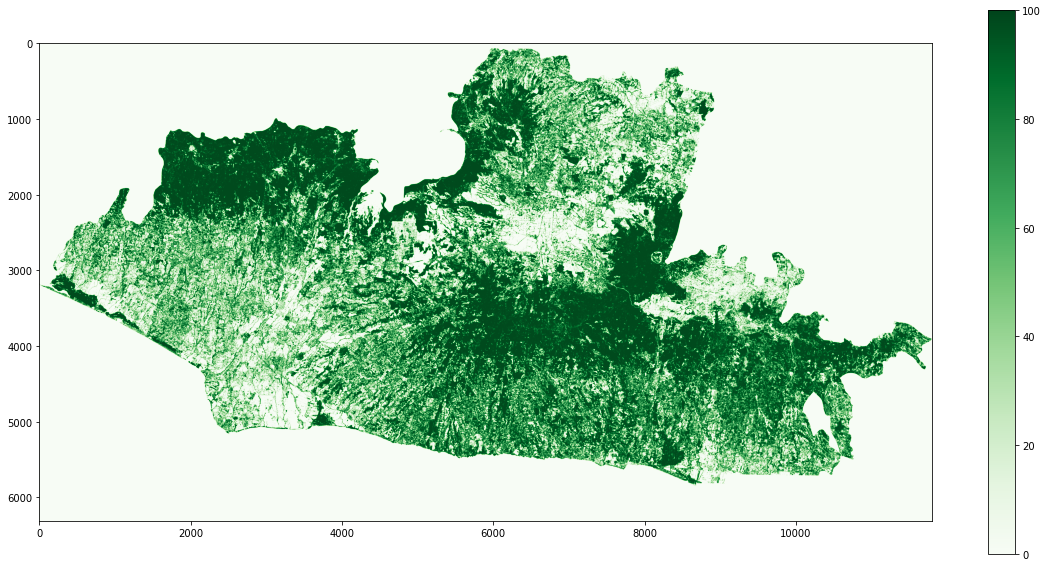

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(tof_data, cmap='Greens', vmin=0, vmax=100)
plt.colorbar()
plt.show()

In [66]:
hansen_data = rs.open("hansen_treecover.tif")
hansen_data = hansen_data.read(1)
print(hansen_data.shape)

(2316, 4331)


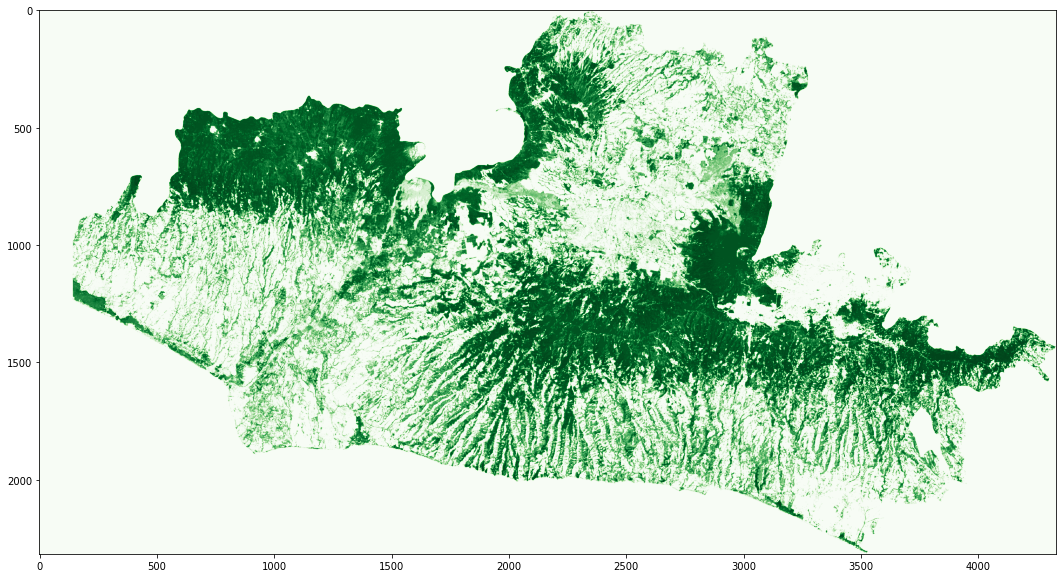

In [67]:
plt.figure(figsize=(20,10))
plt.imshow(hansen_data, cmap='Greens', vmin=0, vmax=100)
plt.show()

## Mask rasters with shapefile

In [68]:
# import shapefile
jurisdictions = gpd.read_file('elsalvador_adm2.geojson')

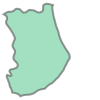

In [69]:
jurisdictions.geometry[0]

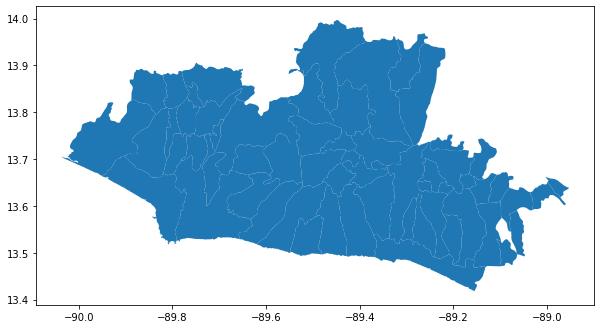

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
jurisdictions.plot(ax=ax);

In [47]:
jurisdictions.head()

,Shape_Leng,Shape_Area,ADM2_ES,ADM2_PCODE,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry
0,0.253137,0.003054,Apaneca,SV0102,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.82207 13.87903, -89.82079 ..."
1,0.326220,0.005182,Concepción de Ataco,SV0104,Concepcion de Ataco,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.81461 13.81050, -89.81467 ..."
2,0.439992,0.007796,Guaymango,SV0106,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.81228 13.69891, -89.81432 ..."
3,0.798428,0.015678,Jujutla,SV0107,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.92748 13.82101, -89.92649 ..."
4,0.281148,0.001747,San Pedro Puxtla,SV0110,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.78200 13.75532, -89.78310 ..."


In [74]:
tof_data = rs.open("sentinel_treecover.tif")
tof_data.shape

(6309, 11801)

In [75]:
def mask_raster(raster, shapefile, data):
    
    '''
    Function takes in a TOF or Hansen raster file for a country,
    masks out jurisdictions based on polygons defined in the shapefile and
    then writes the masked raster to a new file.
    '''
    for i in shapefile.geometry:
        for jurisdiction in shapefile.ADM2_ES:
            
            # crop to each of the geometries in the shapefile
            out_img, out_transform = mask(dataset=raster, shapes=i, crop=True)
            out_meta = raster.meta
            
            # write the masked raster to a new file
            out_meta.update({'driver': 'GTiff',    
                             'dtype': 'uint8',
                             'height': out_img.shape[1],
                             'width': out_img.shape[2],
                             'transform': out_transform})

            outpath = os.path.join(f'clipped_rasters/{data}', f'{str(jurisdiction)}')
            outraster = rs.open(outpath, "w", **out_meta) 
            outraster.write(out_img)
            outraster.close()
           
    return 'Rasters clipped and saved.'

In [76]:
mask_raster(tof_data, jurisdictions, 'TOF')

'Rasters clipped and saved.'

## Calculate % Tree Cover

In [88]:
def calculate_tree_cover(jurisdiction, data): # eventually should take in tof and hansen
    
    # read in the raster
    open_file = rs.open(f'clipped_rasters/{data}/{jurisdiction}')
    clipped_raster = open_file.read(1)
    print(clipped_raster.shape)
    
    # round down to nearest 10th
    def round_down(num, divisor):
        return num - (num%divisor)
    
    rows = round_down(clipped_raster.shape[0], 10)
    columns = round_down(clipped_raster.shape[1], 10)
    j_rounded = clipped_raster[:rows, :columns]
    print(j_rounded.shape)
    
    # reshape grid to (x, 10, x, 10)
    j_reshaped = np.reshape(j_rounded, (int(j_rounded.shape[0] / 10), 10, int(j_rounded.shape[1] / 10), 10))
    print(j_reshaped.shape)
    
    # calculate mean tree cover and mean tree cover per hectare
    j_mean = round(np.mean(j_reshaped), 3)
    j_mean_ha = np.mean(j_reshaped, axis=(1,3))

    
    # check how many hectares have >10% tree cover
    hectares = np.sum(j_mean_ha > 10)
    print(f"{hectares} hectares have >10% tree cover.")
    
    tree_cover = pd.DataFrame(columns=['jurisdiction','tof_perc_cover','tof_forest_ha']) #add hansen after
    
    tree_cover = tree_cover.append({'jurisdiction': jurisdiction, 
                                    'tof_perc_cover': j_mean, 
                                    'tof_forest_ha': hectares}, ignore_index=True)
                                       
    return tree_cover

In [89]:
# test
df = calculate_tree_cover('Acajutla', 'tof')

(770, 336)
(770, 330)
(77, 10, 33, 10)
959 hectares have >10% tree cover.


In [90]:
df

,jurisdiction,tof_perc_cover,tof_forest_ha
0,Acajutla,21.309,959


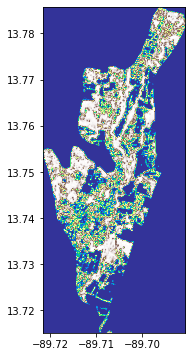

In [101]:
# test one of the clipped files
apaneca_clipped = rs.open('clipped_rasters/Apaneca')

fig, ax = plt.subplots(figsize=(10,6))
show((clipped, 1), cmap='terrain');

In [118]:
# read method returns an np array.
apaneca = apaneca_clipped.read(1)
apaneca.shape

(770, 336)

In [124]:
# first clip to be divisible by 10
apaneca = apaneca[:770, :330]
apaneca.shape

(770, 330)

In [128]:
# reshape to 10x10 grid
apaneca = np.reshape(apaneca, (int(apaneca.shape[0] / 10), 10, int(apaneca.shape[1] / 10), 10))
apaneca.shape

(77, 10, 33, 10)

In [131]:
# take the mean of the arrays on axis 1 and 3, which is the mean tree cover for each hectare
apaneca_mean = np.mean(apaneca, axis = (1,3))
apaneca_mean

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., 60.99, 41.8 , 17.17],
       [ 0.  ,  0.  ,  0.  , ..., 95.3 , 89.53, 78.62],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [132]:
# check how many hectares have >10% tree cover
np.sum(apaneca_mean > 10)

959